[org-toggle-latex-overlays> ](org-toggle-latex-overlays> )[org-toggle-pretty-entities](org-toggle-pretty-entities)




# Engineering applications of mole balances



-   So far you have learned to design a variety of reactors with single reactions occurring in them

-   Usually, we need additional information to tell us which reactor design is better, e.g. a larger volume with low volumetric flow rate vs. a smaller volume with higher volumetric flow rate

-   That information may be the cost of different configurations, or the profit from different configurations




## Total cost example



-   Let us consider a simple model for the total cost of an operation

-   Let the total cost be the operating cost of the reactor plus the cost of the feedstocks

-   The operating cost of a reactor can be determined by amortizing the reactor cost over some length of time, and adding the cost required for maintenance, and paying workers.
    -   The units of this cost will usually be $/volume/time
    -   The cost of operating the reactor then is $C_R = V_R operating_{cost}$

-   Feedstock costs are related to the cost of raw materials times the rate at which they are consumed
    -   The cost associated with each reactant will be $C_{j} = F_j reactant_{cost}$ if $reactant_{cost}$ is in $/mol.

-   Let us consider an example

-   Y is produced at a rate of 90 kmol/min in a CSTR by the reaction $X \rightarrow Y$ at a reaction rate of $r = 0.1 C_X$ (kmol/m^3/min)  with an inlet concentration of $C_{X0} = 1.5$ kmol/m^3.  The reactant X costs \\$1.20 per kmol. The cost of the reactor is \\$0.1 per minute per cubic meter. If we discard unreacted X, what is the minimum cost of making Y?

-   We need to know the volume and volumetric flow that will minimize the total cost.

-   We have a mole balance on X:

\begin{align}
0 = F_{X0} - F_X + r_X V \\
0 = F_{X0} * C_X v_0 - k C_X V
\end{align}

-   We have two unknowns and one equation, but if we specify one variable, we can solve for the other one

-   Let us start by specifying a $v_0$, and solving for $V$
-   Then we calculate the cost

-   Then we vary $v_0$ to minimize the cost

-   There are some bounds on $v_0$: We must have at least 90 kmol/min of X entering the reactor to produce 90 kmol/min of Y
    -   Actually that would be a conversion of 100%, which is not reasonable.
    -   Let us assume 90% conversion is acceptable for now, which means v\_0 must be at least 100 kmol/min / 1.5 mol/m^3 &asymp; 66 m^3/min.



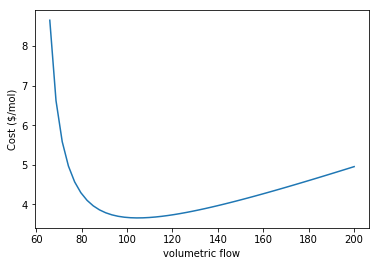

Min cost of $3.655606758832566 at V=104.28571428571428
Optimization terminated successfully.
         Current function value: 3.655521
         Iterations: 19
         Function evaluations: 38
Lowest cost is at a volumetric flow of 104.72140502929688 m^3/min
The lowest cost is $3.6555210486674237


In [13]:
from scipy.optimize import fsolve
import numpy as np

k = 0.1    # rate constant 1/min
Cx0 = 1.5  # initial concentration
Fy = 90.0  # exit molar flow of Y


def objective(V, v0):
    Fx0 = Cx0 * v0
    Fx = Fx0 - Fy
    Cx = Fx / v0
    rx = -k * Cx
    return Fx0 - Fx + rx * V

v0 = np.linspace(66, 200)

reactor_cost = 0.1  # $/m^3
Xcost = 1.20        # $/kmol

# this is a decorator that makes cost work element-wise
@np.vectorize
def cost(v0):
    V, = fsolve(objective, 10000, args=(v0,))
    CR = reactor_cost * V
    CX = v0 * Cx0 * Xcost
    return (CR + CX) / Fy  # cost in $/mol Y

import matplotlib.pyplot as plt
plt.plot(v0, cost(v0))
plt.xlabel('volumetric flow')
plt.ylabel('Cost ($/mol)')
plt.savefig('images/cost.png')
plt.show()

imin = np.argmin(cost(v0))
print('Min cost of ${} at V={}'.format(cost(v0)[imin], v0[imin]))

from scipy.optimize import fmin
v_opt, = fmin(cost, 120)
print('Lowest cost is at a volumetric flow of {0} m^3/min'.format(v_opt))
print('The lowest cost is ${}'.format(cost(v_opt)))

![img](./images/cost.png)

-   The cost at low volumetric flow is dominated by the increasing reactor size

-   The cost at high volumetric flow is dominated by the cost of the feedstock $X$

Show that the costs in the example above are dominated by reactor volume at low flowrate, and reactant cost at high flowrate.




## Profit example



-   Now, let us consider profit

-   Profit is the difference between the value of the products and the cost to make them

-   Say compound X with a concentration of 2.5 kmol / m^3 flows at a rate of 12 m^3/min into a tubular reactor where it is converted to $Y$.

-   The reaction occurs at a rate of $r = 30.0 C_X$ 1/min

-   $Y$ has a value $V_Y$ of $1.50 / kmol, and the cost of reactor operation $C_R$ is $2.50 per minute per m^3.

-   What is the maximum profit?

-   The value of the products will be $F_Y V_Y$ and the operating cost will be $V_R C_R$.

-   We have to compute the exit molar flow of product as a function of reactor volume, and then compute the profit for each volume.

-   Here we set up mole balances on $X$ and $Y$.
    -   It is not strictly necessary, we could just get $F_X$, and compute $F_Y$ by stoichiometry later
    -   Instead, we compute $F_Y$ in the solution



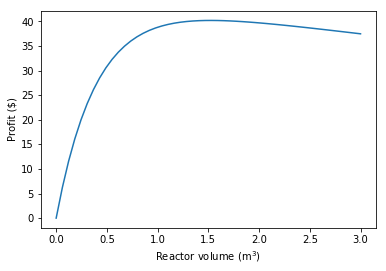

25
Max profit of $40.193141393479685 at V = 1.530612244897959
Optimization terminated successfully.
         Current function value: -40.193337
         Iterations: 11
         Function evaluations: 22
Maximum profit is 40.19333745971681 at V = 1.5226318359375


In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

k = 30.0
CX0 = 2.5 # kmol / m^3
v0 = 12.0 # m^3 / min
FX0 = CX0 * v0
FY0 = 0.0

def dFdV(F, V):
    Fx, Fy = F
    Cx = Fx / v0
    r = k * Cx
    rx = -r
    ry =  r
    dFxdV = rx
    dFydV = ry
    return [dFxdV, dFydV]

Vspan = np.linspace(0, 3)

sol = odeint(dFdV, [FX0, FY0], Vspan)

Fy = sol[:, 1]
V_Y = 1.50 # $/kmol
C_R = 2.50 # $/m^3/min

product_value = Fy * V_Y
operating_cost = Vspan * C_R

profit = product_value - operating_cost
plt.plot(Vspan, profit)
plt.xlabel('Reactor volume (m$^3$)')
plt.ylabel('Profit ($)')
plt.savefig('images/profit.png')
plt.show()


imax = np.argmax(profit)
print(imax)
print('Max profit of ${} at V = {}'.format(profit[imax], Vspan[imax]))


def profit(V, sign=1):
   F = odeint(dFdV, [FX0, FY0], [0, V])
   FY = F[-1, 1]
   profit = FY * V_Y - V * C_R
   return profit * sign

# print(profit(1.53))

from scipy.optimize import fmin

opt_V, = fmin(profit, 1.5, args=(-1,))
print('Maximum profit is {} at V = {}'.format(profit(opt_V), opt_V))

In [21]:
def profit(V, sign=1):
   F = odeint(dFdV, [FX0, FY0], [0, V])
   FY = F[-1, 1]
   profit = FY * V_Y - V * C_R
   return profit * sign

profit (10, 1)

19.999999999388244

![img](./images/profit.png)

[scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html)

-   You can see a maximum in profit at a reactor volume of about 1.5 m^3.

-   To get a more quantitative answer, we need to use optimization

-   We need to define an objective function to minimize

-   The profit goes through a maximum, so -profit will go through a minimum

-   We will use an optional argument to our profit function that determines the sign of the return value
    -   For the optimization we set the sign to be -1
    -   After we have a solution we use the default sign of +1 to compute the profit
    -   This is just for convenience. You could multiply by &plusmn; 1 as needed.



In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

k = 30.0
CX0 = 2.5 # kmol / m^3
v0 = 12.0 # m^3 / min
FX0 = CX0 * v0
FY0 = 0.0

def dFdV(F, V):
    Fx, Fy = F
    Cx = Fx / v0
    r = k * Cx
    rx = -r
    ry =  r
    dFxdV = rx
    dFydV = ry
    return [dFxdV, dFydV]

V_Y = 1.50 # $/kmol
C_R = 2.50 # $/m^3/min

def profit(V, sign=1): # the default value of sign is 1
    Vspan = np.linspace(0, V)
    sol = odeint(dFdV, [FX0, FY0], Vspan)
    Fx, Fy = sol[-1] # at exit

    product_value = Fy * V_Y
    operating_cost = V * C_R

    profit = product_value - operating_cost
    return profit * sign

print(profit(5))
from scipy.optimize import fmin

V_opt, = fmin(profit, 1.5, args=(-1,))

print('The maximum profit is ${0:1.2f} at V={1:1.2f} m^3'.format(profit(V_opt), V_opt))

32.4998323014
Optimization terminated successfully.
         Current function value: -40.193337
         Iterations: 11
         Function evaluations: 22
The maximum profit is $40.19 at V=1.52 m^3


-   The point of these examples is to illustrate how to combine mole balance and reactor design equations with additional information to help select the best design
    -   You may want to minimize total cost
    -   or maximize profit

-   Other applications might be finding operating conditions to avoid certain pressure increases, or minimizing a pressure drop

[quiz-3](quiz-3)

